In [1]:
'''
Location of 'project' directory.
'''
import os

os.chdir('..')
os.chdir('..')

BASE_DIR = os.getcwd()

# BASE_DIR is working directory for this notebook
print(os.getcwd())

D:\ML\Projects\htr\htr-github


## Import libraries

In [2]:
import string
import json
import numpy as np
import matplotlib.pyplot as plt

from htr.generator import DataGenerator
from htr.network import *

from htr.evaluation import ocr_metrics

from tensorflow.keras.models import Model

# Load the TensorBoard notebook extension
%load_ext tensorboard

***Filepaths***

In [3]:
dataset_path = os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting.hdf5')
output_path = os.path.join(BASE_DIR, 'htr', 'data', 'output-bangla')
target_path = os.path.join(output_path, 'checkpoint_weights_bangla.hdf5')

***Parameters***

In [4]:
input_size = (1024, 128, 1)
max_text_len = 128
batch_size = 128
epochs = 50

bangla_chars = json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'bangla-characters.json')))
charset = ''.join(bangla_chars) + string.punctuation + ' '

***DataGenerator class***

In [5]:
generator = DataGenerator(dataset_path=dataset_path, 
                          input_size=input_size, 
                          batch_size=batch_size, 
                          max_text_len=max_text_len, 
                          charset=charset)

print('Images:', generator._size)

Images: {'train': 20373, 'val': 424, 'test': 424}


## Model

In [6]:
inputs, outputs = puigcerver(input_size=input_size, d_model=generator.tokenizer.vocab_size + 1)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 128, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 128, 16)     64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 128, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 64, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 64, 32)      

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ctc_loss)

# Load weights from target_path
if os.path.isfile(target_path):
    model.load_weights(target_path)
    print('===== Pre-trained weights loaded =====')

===== Pre-trained weights loaded =====


## Training

In [23]:
callbacks = get_callbacks(logdir=output_path, 
                          checkpoint_filepath=target_path, 
                          verbose=1, 
                          stop_patience=20, 
                          reduce_patience=15)

In [ ]:
model.fit(x=generator.next_train_batch(), 
          steps_per_epoch=generator._steps['train'], 
          validation_data=generator.next_val_batch(), 
          validation_steps=generator._steps['val'], 
          epochs=epochs, 
          callbacks=callbacks, 
          verbose=1)

***Training history from CSVLogger callback***

Min val_loss: 1.6234517097473145
Min val_loss epoch: 109


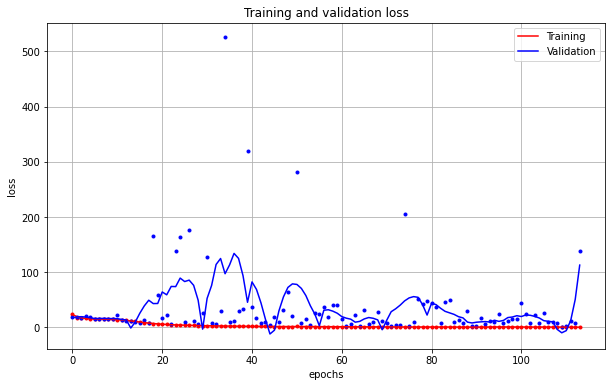

In [8]:
from pandas import read_csv
from scipy.signal import savgol_filter
from ipywidgets import interact

path = os.path.join(output_path, 'epochs.log')
if os.path.isfile(path):
    history = read_csv(path)
    loss = history['loss']
    val_loss = history['val_loss']

    print('Min val_loss:', np.min(val_loss))
    print('Min val_loss epoch:', np.argmin(val_loss))

    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss, 'r.')
    plt.plot(val_loss, 'b.')
    # Smoothing
    plt.plot(savgol_filter(loss, 11, 3), 'r-', label='Training')
    plt.plot(savgol_filter(val_loss, 11, 3), 'b-', label='Validation')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid('on')
    plt.show()
    
else:
    print("File doesn't exist")

***Logs from Tensorboard***

If tensorboard gets timed out or doesn't show up, it might be running on http://localhost:6006/.

In [ ]:
%tensorboard --logdir {output_path}

## Prediction | Evaluation

***Validation set***

In [16]:
print('           VALIDATION SET           ')
Y_pred = model.predict(x=generator.next_val_batch(), steps=generator._steps['val'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['val']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           VALIDATION SET           
4/4 [==============================] - 19s 5s/step
Y_pred shape: (424, 128, 132)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
4/4 [==============================] - 8s 2s/step

CTC decoded predictions len: 424
Character Error Rate (%) : 20.2973
Word Error Rate (%) : 40.8019
Sequence Error Rate (%) : 40.8019


***Test set***

In [17]:
print('           TEST SET           ')
Y_pred = model.predict(x=generator.next_test_batch(), steps=generator._steps['test'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['test']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           TEST SET           
4/4 [==============================] - 18s 4s/step
Y_pred shape: (424, 128, 132)
4/4 [==============================] - 10s 3s/step

CTC decoded predictions len: 424
Character Error Rate (%) : 21.5678
Word Error Rate (%) : 40.0943
Sequence Error Rate (%) : 40.0943
